# RCC - UChicago, 2025

## Geospatial Python Part 2: Scaling Geospatial Workflows with Dask

### Instructors:

- Hamid Dashti (hdashti@uchicago.edu)
- Parmanand Sinha (pnsinha@uchicago.edu)

### Commands

- `Shift` + `Enter`: Run and move to the next cell.
- `Ctrl` + `Enter`: Run the cell in place.
- `Alt` + `Enter`: Run and insert a new cell below.
- To delete a cell: Press `esc` to enter command mode, then press `cmd`+`m`+`d`.
- To insert a new cell below: Press `esc` then `b`.
- To insert a new cell above: Press `esc` then `a`.


## Topics

**Part 2**

- **Introduction to xarray:**
  - Data exploration
  - Indexing
- **Visualizing data with xarray:**

  - Static plots
  - Interactive plotting

- **Computation with Xarray:**

  - Built-in functions
  - Costume functions

  **End with and exercise**

**Second Half:**

- **Scaling computations with Dask:**
  - Handling out-of-memory (large) datasets
  - Parallel programming
- **Accessing Cloud-Based Data Catalogs:**
  - Searching Earth Engine and Planetary Computer data (explore a STAC Catalog)
  - Integrating cloud data into xarray workflows

If time allows:

- **Running Dask on HPC/HTC (Requires CHTC accounts):**
  - Setting up Dask on UW HPC using vscode


# **Geospatial Data Formats for Climate and Satellite Data**

## Key Formats

Common geospatial file formats frequently used for climate and satellite data:

### NetCDF (Network Common Data Form; <u>Our focus today</u>)

**Purpose:**

- Storing and sharing multidimensional scientific array-based data with comprehensive metadata.

**Key Features:**

- Self-describing with rich metadata for efficient algorithm development.
- Scalable for efficient access to subsets of large datasets, even remotely.
- Appendable for data addition without structure redefinition.
- Sharable with support for multi-user access.

**Common Applications:**

- Gridded climate data
- Satellite images
- Earth system model outputs

**CF Conventions (Climate and Forecast):**

- Standardized metadata for self-description and interoperability.
- Ensures variables have associated descriptions, physical units, and spatiotemporal coordinates.
- Enables software tools to work effectively with minimal user intervention.

**Links:**

- [NetCDF Website](https://www.unidata.ucar.edu/software/netcdf/)
- [CF Conventions](http://cfconventions.org/)

### HDF5 (Hierarchical Data Format version 5)

**Purpose:**

- Storing complex heterogeneous datasets.

**Key Features:**

- Hierarchical data organization with groups and datasets.
- Self-describing with metadata within the file.
- Multiple data type support (integers, floats, strings, complex numbers).
- Chunking and compression for efficient storage and access.
- Large file and dataset support (terabytes to petabytes).
- Parallel processing capabilities.

**Common Applications:**

- Many satellite data (e.g. MODIS) is HDF5.
- Earth system model outputs.

**Links:**

- [HDF5 Website](https://www.hdfgroup.org/solutions/hdf5/)

### Zarr

**Purpose:**

- Efficient parallel processing and cloud storage of large datasets.

**Key Features:**

- Stores data in chunks across multiple files. Makes reading and writing large datasets faster.
- Optimized for high-performance computing (HPC), high-throughput computing (HTC), and cloud environments.

**Common Applications:**

- Large-scale scientific datasets
- Cloud-based data analysis

**Links:**

- [Zarr Website](https://zarr.dev/)

### STAC (SpatioTemporal Asset Catalog)

**Purpose:**:

- Simplify search and discovery of geospatial data across different providers and platforms.
- Enable interoperability between various tools and applications working with geospatial data.
- Facilitate easier cloud storage and access for large datasets.

**Key Features:**

- Uses JSON files to describe assets, providing information like location, time, data type, metadata, and availability.
- Flexible and extensible, allowing customization for specific data types and needs.

**Links:**

- [STAC Website](https://stacspec.org/en)


### Large Data and Speed: The Next Challenge

We've covered the basics of climate data processing in Python. Now, let's tackle the real challenges:

1. **Out-of-memory data:** What happens when datasets are too large to fit in memory?
2. **Speeding up computations:** How can we analyze data faster, especially with large datasets?

In the next session, we'll introduce `Dask`, a powerful tool for handling these issues.


## Introducing Dask


**What is Dask?** - Dask is an open-source library designed to provide parallelism to the existing Python stack. It provides integrations with Python libraries like NumPy, Pandas, **Xarray** and scikit-learn to enable parallel execution across multiple cores, processors, and computers without having to learn new libraries or languages.

In [ ]:
!pip install -q gdown xarray netCDF4 matplotlib numpy

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import gdown
import os

# 1. Get the data

In [ ]:
# Create a data directory if it doesn't exist
os.makedirs("./data", exist_ok=True)

# Download the air temperature NetCDF file
air_temp_url = "https://drive.google.com/file/d/1M8HutVe3q2WcQzmNFwHFCobIbmwGLG3s/view?usp=drive_link"
air_temp_output = "./data/air.mon.mean.nc"
gdown.download(air_temp_url, air_temp_output, quiet=False, fuzzy=True)

# Download the Landsat NetCDF file
landsat_url = "https://drive.google.com/file/d/1ppdpLVRZ-GTumHm1086XPLl18661hcG_/view?usp=drive_link"
landsat_output = "./data/small_landsat.nc"
gdown.download(landsat_url, landsat_output, quiet=False, fuzzy=True)

In [92]:
from dask.distributed import Client
import multiprocessing

In [136]:
from dask.distributed import Client

# Get the number of cores
n_cores = 2
# Specify the number of threads per worker
threads_per_worker = 2  # adjust this based on your workload

client = Client(n_workers=n_cores, threads_per_worker=threads_per_worker)
client

/Users/hamiddashti/miniforge3/envs/nasa_env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61532 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:61533' processes=2 threads=4, memory=32.00 GiB>

Lets start with a simple example of a 2D array of numbers:


In [137]:
shape = (1000, 4000)
ones_np = np.ones(shape)
print("Size:", ones_np.nbytes / 1e6, "MB")

Size: 32.0 MB


We can create an equivalent Dask array using dask.array.ones:


In [138]:
ones_da = dask.array.ones(shape)
ones_da

# Note: 1 MiB = 1,048,576 bytes

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In this example we have not "chunk" the data yet. There is only one chunk with same shape as our Array.


Now lets chunk the data into 1000 by 1000 blocks:


In [96]:
chunks_size = (1000, 1000)
ones_da = dask.array.ones(shape, chunks=chunks_size)
ones_da

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

pay close attention to the chunks size and the memory usage.

### Dask graph
A Dask graph, often referred to as a Dask task graph or computation graph, represents the logical structure of a computation. In this graph, each node represents a task or operation, and the edges represent dependencies between these tasks.

**Thus, note that Dask does not implement any computations until you explicitly request them. At this stage, Dask only graphs the "workflow" of all tasks you've asked it to perform for you.**

You can utilize the dask.array.visualize() function to visualize the Dask graph.


In [97]:
# Uncomment if you get error related to graphviz when plotting
#!pip uninstall graphviz
# conda install -c conda-forge graphviz
# conda install -c conda-forge python-graphviz


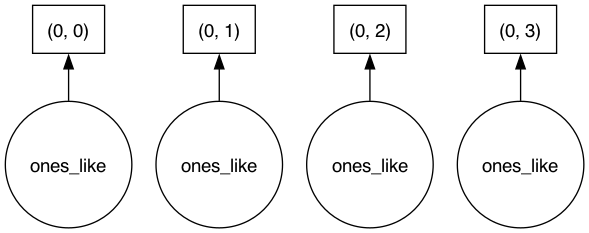

In [98]:
# Visualize the dask graph
dask.visualize(ones_da)

Similar to numpy, we can perform arithmetic operations on dask arrays:


In [139]:
# Dask is lazy, it graphs the tasks but not doing it, until we specifically ask for it through compute
ones_mean = ones_da.mean()
ones_mean

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

One key distinction between Dask and NumPy lies in Dask's "lazy" evaluation approach, where computations are deferred until explicitly requested.

The provided code represents merely the computation graph, outlining the sequence of operations, rather than executing the computations themselves:


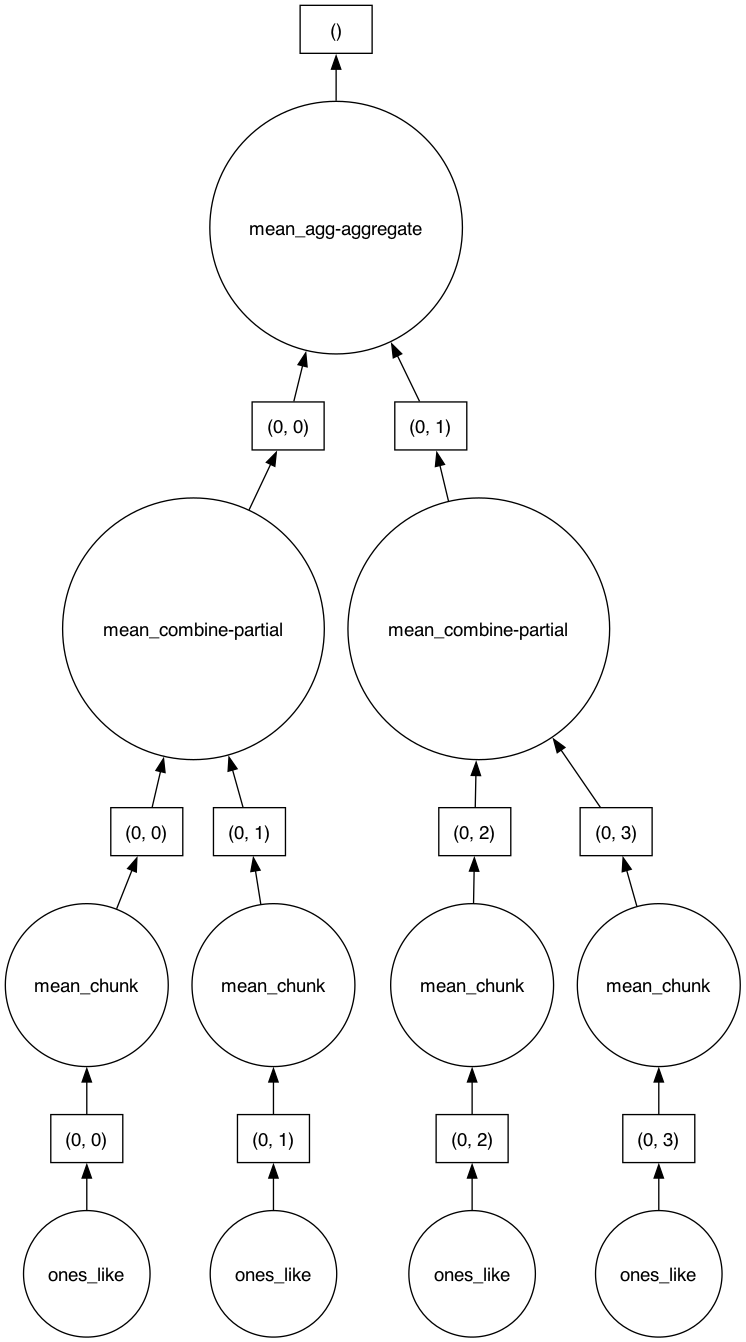

In [100]:
dask.visualize(ones_da.mean())

To compute the mean, we can use the .compute() method to trigger the computation and get the result as a NumPy array.


In [101]:
# To calculate
ones_mean.compute()

np.float64(1.0)

### Parallelize the calculation

Now we know about chunking, what about parallel computing.


The following code is designed to take precisely 4 seconds when executed sequentially:


In [102]:
import time


def inc(x):
    # Takes two seconds to compute
    time.sleep(2)
    return x + 1


def dec(y):
    # Takes one second to compute
    time.sleep(1)
    return y - 1


def add(x, y):
    # Takes one seconds to compute
    time.sleep(1)
    return x + y

In [103]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)

CPU times: user 525 ms, sys: 206 ms, total: 731 ms
Wall time: 4.01 s


with dask.delayed we can make the above computation lazy. Meaning we only design the computation graph but not doing the computation.


In [104]:
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

In [105]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)

CPU times: user 104 µs, sys: 42 µs, total: 146 µs
Wall time: 137 µs


Note how fast the cell runs! This is because the dask.delayed calls are building up a task graph, but not actually executing it.

Lets visualize the computation graph:


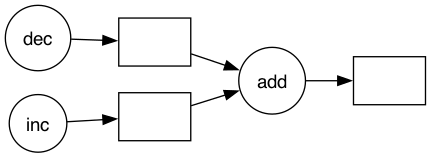

In [106]:
# Visualize the dask graph for calculation of z
z.visualize(rankdir="LR")

What is your guess for the time it will take to compute z?


In [107]:
%%time
z.compute()

CPU times: user 485 ms, sys: 197 ms, total: 682 ms
Wall time: 3.02 s


3

### Dask-Xarray for Large-Scale Gridded Geospatial Data Analysis

You've already explored the individual strengths of Xarray and Dask - the former providing a familiar and intuitive interface for labeled arrays, and the latter unlocking parallel processing on massive datasets. Now, let's delve into the exciting stuff when they're combined:

**Key Advantages:**

- **Parallel Processing:** Dask distributes data and computations across multiple cores or worker processes, enabling significantly faster analysis on large datasets. Operations like aggregation, reshaping, and arithmetic leverage distributed computing power, drastically reducing analysis times.
- **Lazy Evaluation:** Dask-Xarray adopts a "lazy" approach, deferring actual computations until absolutely necessary.
  - This optimizes resource utilization by focusing only on the required parts of complex workflows, further boosting efficiency.
  - Reproducibility of the research. Computation the metadata than the data is more transferable, especially if the metadata is the same across datasets (e.g. STAC)
- **Streaming:** For datasets exceeding disk capacity, Dask-Xarray employs streaming to process data in chunks, eliminating the need to load everything at once.
- **Familiar API:** Xarray's intuitive API, reminiscent of NumPy and pandas, ensures a consistent experience regardless of data location: in-memory arrays or out-of-memory Dask arrays. This minimizes the learning curve and simplifies code adaptation.
- **Flexibility:** Dask-Xarray adapts to your hardware and software environment, whether you're working on a single workstation, multi-core machine, cluster, or cloud platform.


OK! now we know how to use Dask to scale our computation. Let's go back to our air temprature dataset and see how we can use Dask to scale our computation.


If we just open the DataArrays it will be loaded into memory:


In [108]:
ds = xr.open_dataset("air.mon.mean.nc")
da = xr.open_dataarray("air.mon.mean.nc")
da

<xarray.DataArray 'air' (time: 928, lat: 360, lon: 720)> Size: 962MB
[240537600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2025-04-01
Attributes:
    long_name:      Monthly mean of surface temperature
    units:          degK
    dataset:        NOAA/NCEP GHCN CAMS
    var_desc:       Air Temperature
    level_desc:     Surface
    statistic:      Mean
    parent_stat:    Other
    standard_name:  air_temperature
    cell_methods:   time: mean
    valid_range:    [150. 400.]
    actual_range:   [-49.21874 335.75   ]

If data is huge then this approach fails! so we need to use `chunks` (remember from dask) argument to load the data in chunks:


In [109]:
# Open the air temprature Dataset with Dask enabled
da = xr.open_dataarray(
    "air.mon.mean.nc",
    chunks={
        "time": 100,
        "lat": "auto",
        "lon": "auto",
    },
)
da

<xarray.DataArray 'air' (time: 928, lat: 360, lon: 720)> Size: 962MB
dask.array<open_dataset-air, shape=(928, 360, 720), dtype=float32, chunksize=(100, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2025-04-01
Attributes:
    long_name:      Monthly mean of surface temperature
    units:          degK
    dataset:        NOAA/NCEP GHCN CAMS
    var_desc:       Air Temperature
    level_desc:     Surface
    statistic:      Mean
    parent_stat:    Other
    standard_name:  air_temperature
    cell_methods:   time: mean
    valid_range:    [150. 400.]
    actual_range:   [-49.21874 335.75   ]

- The data has been loaded as a Dask array, with the chunks argument determining how the data is partitioned into manageable chunks.

- This implies that the entire dataset is not loaded into memory; instead, a computational graph is constructed.
- This graph consists of tasks that are executed on-demand, following a "lazy" evaluation strategy similar to the example demonstrated at the beginning of the session.


Extract data from the dataset there are two ways:

1. `.data` which returns a dask array
2. `.to_numpy` and `.values`, which means it will call the `compute()`

- Use `.to_numpy` instead of `.values` as it retruns more generlizable array (e.g. sparse arrays)


In [110]:
da.data

dask.array<open_dataset-air, shape=(928, 360, 720), dtype=float32, chunksize=(100, 360, 720), chunktype=numpy.ndarray>

Note that the data is a dask array and lazy!


To get the numpy array use `.to_numpy()` method:


In [111]:
data = da.to_numpy()
print(type(data))
print(data)

<class 'numpy.ndarray'>
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [n

P.S. Don't worry about the nans, this is land temperature data and it is expected to have nans over the ocean and other places.


### Lazy computation


As expected, the computation on xarray when calling chunks is lazy.

It means that the actual computation is deferred until it is explicitly needed.


Lets do an example of a simple calculation with Dask-xarray by taking the mean:


In [112]:
mean = da.mean()
std = da.std()
mean_std = mean + std
mean_std

<xarray.DataArray 'air' ()> Size: 4B
dask.array<add, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

Note its fast since its a lazy computation ---> no actual computation is done.


visualize the dask graph for this calculation:


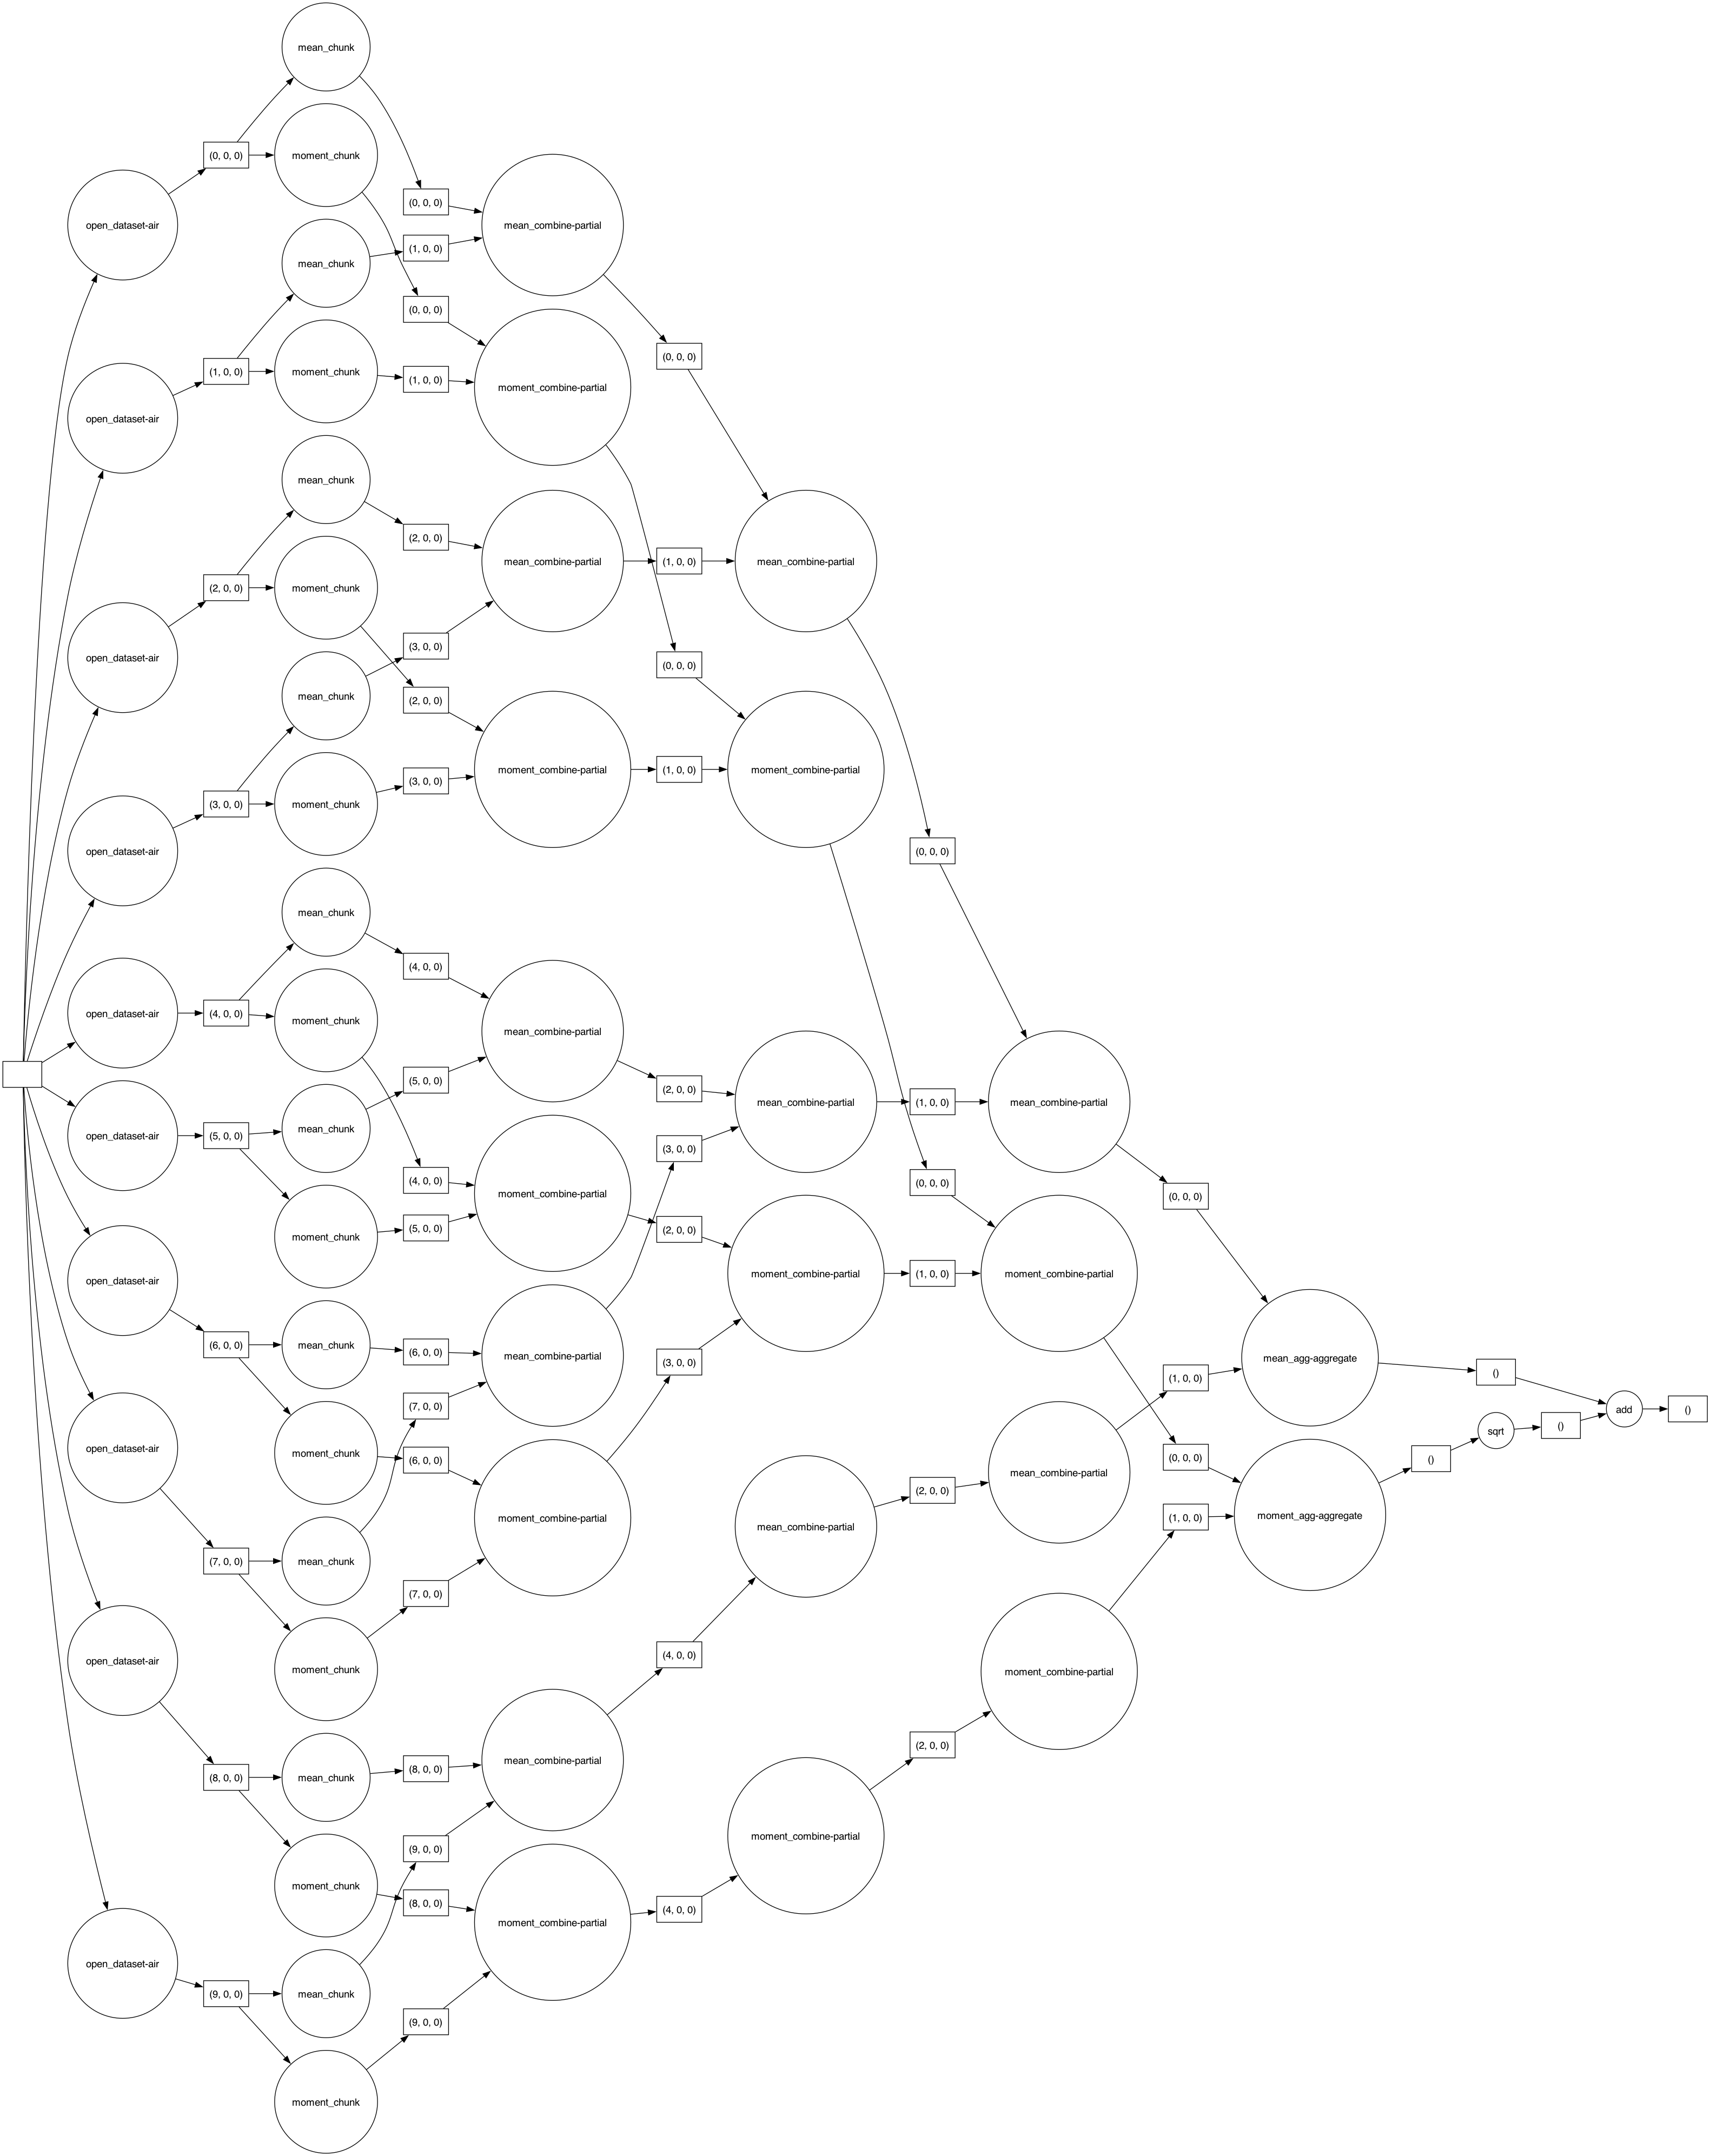

In [113]:
dask.visualize(mean_std, rankdir="LR")

There are various ways to perform the computation:

1. `.compute()`: returns an xarray object. Recommended for smaller datasets where outputs are small enough to fit into memory.
2. `.load()`: similar to compute but returns a dask object. (Not generally recommended for out-of-memory situations).
3. `.persist():` does the computation but holds the results in the distributed cluster memory. Most common for out-of-memory situations but it requires access to clusters/clouds.


In [114]:
mean_std_calculated = mean_std.compute()

Now dask is executing the graph and calculating the result.


In [115]:
mean_std_calculated

<xarray.DataArray 'air' ()> Size: 4B
array(299.42017, dtype=float32)

In [116]:
mean_std.load()

<xarray.DataArray 'air' ()> Size: 4B
array(299.42017, dtype=float32)

#### Calculate the trend but with Dask


In [117]:
da_annual = da.resample(time="Y").mean()
da_annual = da_annual.chunk(dict(time=-1))
da_annual = da_annual.chunk({"lat": 100, "lon": 100, "time": -1})
da_annual

/Users/hamiddashti/miniforge3/envs/nasa_env/lib/python3.9/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


<xarray.DataArray 'air' (time: 78, lat: 360, lon: 720)> Size: 81MB
dask.array<rechunk-merge, shape=(78, 360, 720), dtype=float32, chunksize=(78, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 624B 1948-12-31 1949-12-31 ... 2025-12-31
Attributes:
    long_name:      Monthly mean of surface temperature
    units:          degK
    dataset:        NOAA/NCEP GHCN CAMS
    var_desc:       Air Temperature
    level_desc:     Surface
    statistic:      Mean
    parent_stat:    Other
    standard_name:  air_temperature
    cell_methods:   time: mean
    valid_range:    [150. 400.]
    actual_range:   [-49.21874 335.75   ]

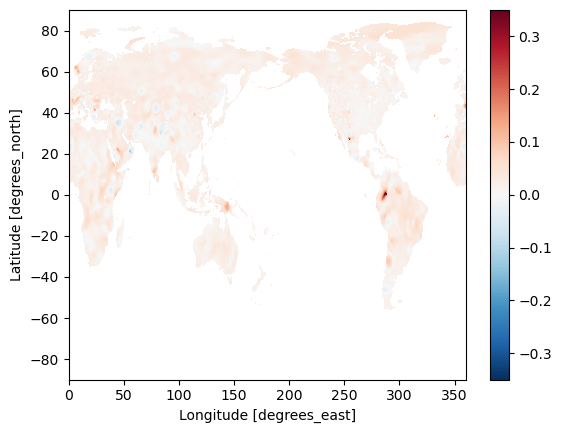

In [118]:
# Define a function that calculates the linear trend using numpy polyfit
def linear_trend(y):
    # y is the variable of interest
    # Check if there is any NaN in y
    if np.any(np.isnan(y)):
        # Return NaN as slope
        return np.nan
    else:
        # Create an array of indices as x
        x = np.arange(len(y))
        # Return only the slope of the linear fit
        return np.polyfit(x, y, 1)[0]


trend = xr.apply_ufunc(
    linear_trend,
    da_annual.variable,
    input_core_dims=[["time"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)
trend_dataarray = xr.DataArray(
    trend, dims=["lat", "lon"], coords={"lat": ds.lat, "lon": ds.lon}
)
trend_dataarray.plot()

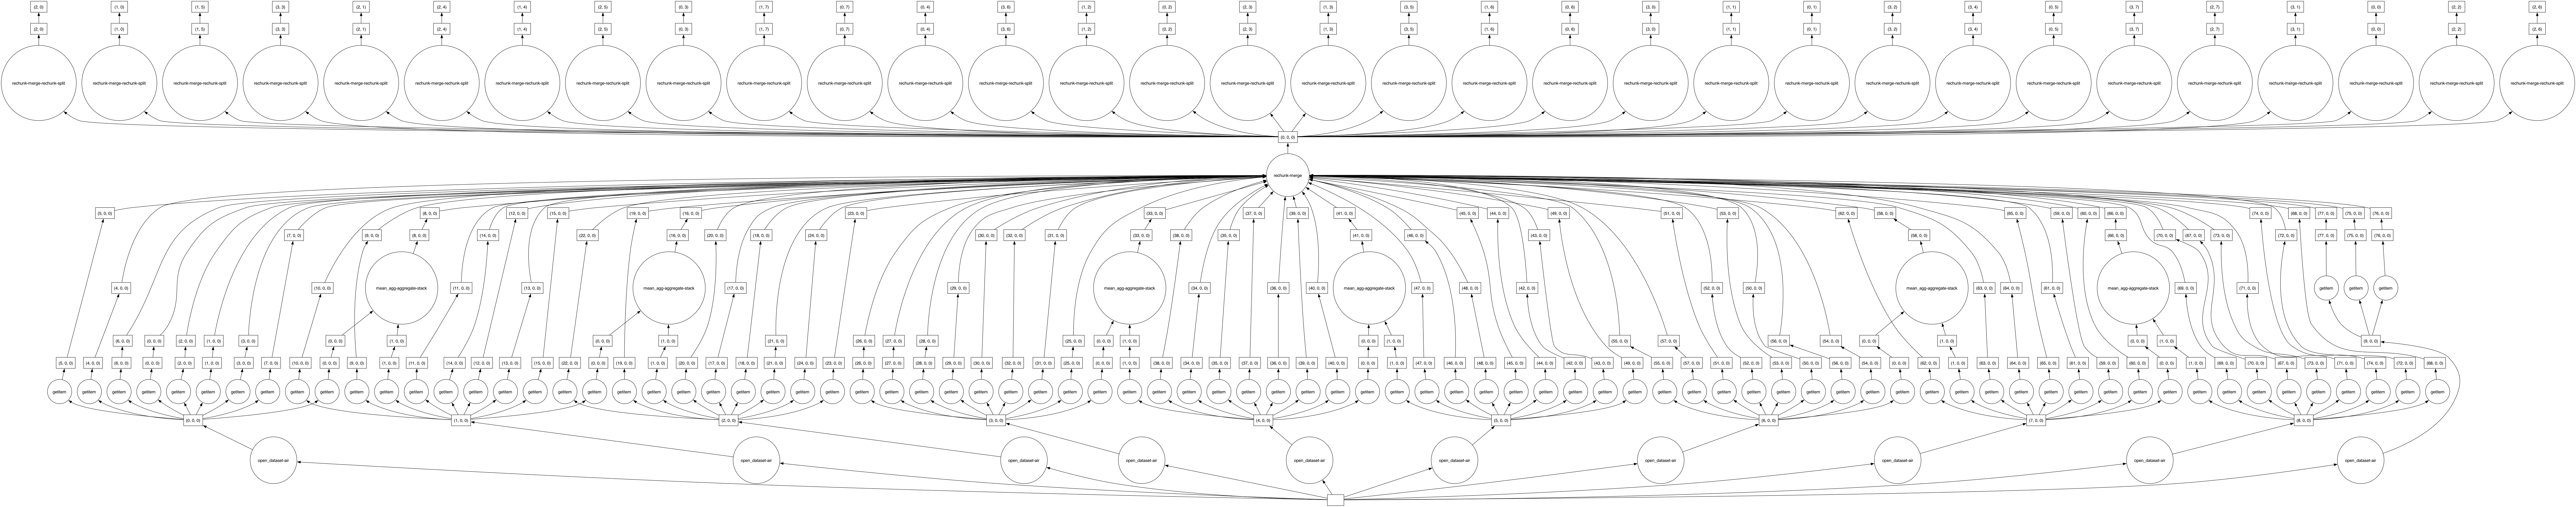

In [119]:
from dask import optimize

(optimized,) = optimize(trend.data)
optimized.visualize()

When using Dask to parallelize computations, there can be overhead associated with parallelization, chunking, and data movement between workers. In some cases, for smaller datasets, the overhead of parallelization can outweigh the benefits of parallel processing, resulting in longer execution times compared to a non-parallelized approach.

In this specific case, with a small array (77 time steps, 360 latitudes, and 720 longitudes), the overhead introduced by Dask's parallelization may dominate the computation time. Dask is designed to handle larger-than-memory datasets efficiently by breaking them into smaller chunks and processing them in parallel. However, for smaller datasets that can fit into memory, the overhead of parallelization may outweigh the benefits.


#### Real out-of-memory-example:

**Do not try to visualize! Its too big and will fail**

In [120]:
bigshape = (200000, 40000)
chunk_shape = (1000, 1000)  # define your chunk shape
big_ones = dask.array.ones(bigshape, chunks=chunk_shape)
print("Size is:", big_ones.nbytes / 1e9, "GB! To big to fit in memory")
big_ones

Size is: 64.0 GB! To big to fit in memory


dask.array<ones_like, shape=(200000, 40000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Lets make a fake xarray object and give it fake lat and lon ( in real world this big data could be your geospatial satellite/climate data).


In [121]:
big_ones_xr = xr.DataArray(
    big_ones,
    dims=["lat", "lon"],
    coords={"lat": np.arange(bigshape[0]), "lon": np.arange(bigshape[1])},
    name="big_ones",
    attrs={"units": "m"},
)
big_ones_xr

<xarray.DataArray 'big_ones' (lat: 200000, lon: 40000)> Size: 64GB
dask.array<ones_like, shape=(200000, 40000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int64 2MB 0 1 2 3 4 5 ... 199995 199996 199997 199998 199999
  * lon      (lon) int64 320kB 0 1 2 3 4 5 ... 39995 39996 39997 39998 39999
Attributes:
    units:    m

Do big calculations with Dask

In [122]:
big_mean = big_ones.mean() + big_ones.std()

In [123]:
from dask.diagnostics import ProgressBar

ProgressBar().register()
with ProgressBar():
    result = big_mean.compute()
result

np.float64(1.0)

### Practice:

- Try to chunk the data along the time dimension and calculate the linear trend using the apply_ufunc function. What do you observe?
- Also experiement with different lat and lon chunk sizes and examine the difference in execution time.


Close Dask client


In [124]:
client.close()

# **Bonus section:** Microsoft planetary computer uses Xarray and Dask for Gepspatial data analysis

## Downloading Data from Microsoft Planetary Computer

The [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) is a powerful cloud platform specifically designed for researchers in climate and environmental fields. It provides **unprecedented access to a vast repository of data**, including:

- **Climate observations**
- **Satellite imagery**
- **Model outputs**

The Planetary Computer leverages the **STAC API (SpatioTemporal Asset Catalog)**, a standardized interface that makes it easy to discover, search, and access datasets based on specific criteria like location, time period, and data type.

**Here's a quick overview of the process:**

**1. Explore the Data Catalog:** Browse the Planetary Computer's extensive collection of datasets through the user-friendly Data Catalog. Filter by parameters like spatial coverage, temporal resolution, and data type to find the resources relevant to your research.

**2. Utilize the STAC API:** Interact with the data programmatically using the STAC API. This protocol enables flexible querying, subsetting, and retrieval of specific data segments you need for your analysis.

**3. Download or Process Data:** Download the retrieved data directly to your local machine or leverage cloud-based processing environments within the Planetary Computer platform.

**Additional Resources:**

- **[Official Documentation](https://planetarycomputer.microsoft.com/docs/overview/about)** .
- **[Catalog](https://planetarycomputer.microsoft.com/catalog)**
- **[Community](https://github.com/microsoft/PlanetaryComputer)**


Load the libraries


In [125]:
!pip install pystac-client planetary-computer odc.stac

In [126]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
from pystac.extensions.eo import EOExtension as eo

To access the data, we’ll create a pystac_client.Client. We’ll explain the modifier part later on, but it’s what lets us download the data assets.


In [127]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

Define area of interest


In [128]:
bbox_of_interest = [-122.001, 47, -122, 47.001]
time_of_interest = "2021-01-01/2021-12-31"
# area_of_interest = {"type": "Point", "coordinates": [-122.2751, 47.5469]}

Search the catalog for the landsat data collection 2 for the year 2021


In [129]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    # intersects=area_of_interest,
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 11 Items


Inspect one item to see what it looks like


In [130]:
items = list(items)
items[0]

<Item id=LE07_L2SP_045027_20211030_02_T1>

Download the data where each item is a time step


In [131]:
import xarray as xr

bands_of_interest = ["nir08"]
data_list = []

for item in items:
    data = odc.stac.stac_load(
        [item], bands=bands_of_interest, bbox=bbox_of_interest
    ).isel(time=0)
    data_list.append(data)

combined_data = xr.concat(data_list, dim="item")
combined_data

<xarray.Dataset> Size: 508B
Dimensions:      (item: 11, y: 4, x: 4)
Coordinates:
  * y            (y) float64 32B 5.206e+06 5.206e+06 5.206e+06 5.206e+06
  * x            (x) float64 32B 5.759e+05 5.76e+05 5.76e+05 5.76e+05
    spatial_ref  int32 4B 32610
    time         (item) datetime64[ns] 88B 2021-10-30T17:42:50.964812 ... 202...
Dimensions without coordinates: item
Data variables:
    nir08        (item, y, x) uint16 352B 0 0 0 0 ... 14730 15096 14854 14416

Do some plotting


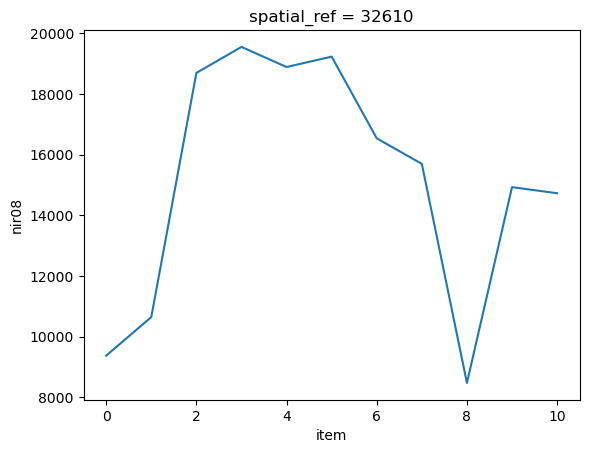

In [132]:
combined_data.nir08.mean(["x", "y"]).plot()

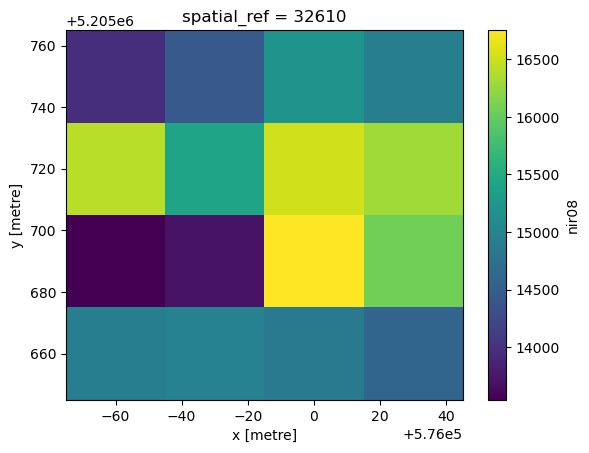

In [133]:
combined_data.nir08.mean("item").plot()

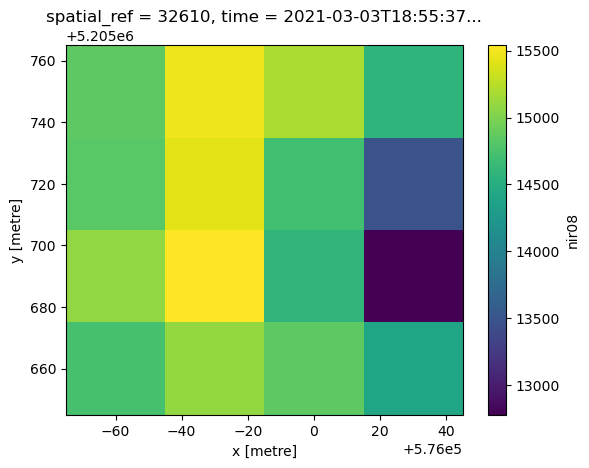

In [134]:
data["nir08"].plot()